In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [3]:
# Management Modules
import os
import random
from glob import glob
from tqdm import tqdm
from collections import Counter

# Data loading and transformation
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Pre-trained models
from tensorflow.keras.applications import ResNet50V2, ResNet152V2, MobileNetV2, Xception

# Model Layers
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Model Checkpoints
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Hyertunig and Metrices
from keras_tuner.tuners import Hyperband
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Set up random seed
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Specify the root file path
directory_path = "/content/drive/MyDrive/dataset/training_set"
N_CLASSES = 10
IMAGE_SIZE = (224, 224, 3)


def create_callbacks(name, patience):
    """
    Create a list of callbacks for model training.

    Parameters:
        name (str): Name of the model for saving purposes.
        patience (int): Number of epochs to wait for improvement in validation loss.

    Returns:
        list: List of callbacks including EarlyStopping and ModelCheckpoint.
    """
    return [
        EarlyStopping(patience=patience, restore_best_weights=True, verbose=1),
        ModelCheckpoint(name + ".h5", save_best_only=True, monitor="val_loss")
    ]


# Collect the class names
class_names = os.listdir(directory_path)

# Show the information
print(f"Number of Classes: {N_CLASSES}")
print("Class Names:")
for index, name in enumerate(class_names):
    print(f"{index + 1:2}. {name}")

# Compute the sample size for each class
class_sample_size = []
for class_name in class_names:
    class_path = os.path.join(directory_path, class_name)
    if os.path.isdir(class_path):
        file_names = os.listdir(class_path)
        class_sample_size.append(len(file_names))
    else:
        print(f"Invalid directory path: {class_path}")

Number of Classes: 10
Class Names:
 1. beaches
 2. foods
 3. dinosaurs
 4. flowers
 5. monuments
 6. peolpe_and_villages_in_Africa
 7. horses
 8. mountains_and_snow
 9. elephants
10. bus


In [5]:
# Calculate the total number of images
total_n_images = sum(class_sample_size)

# Calculate the percentage of sample size for each class
percentage_sample_size = [value / total_n_images * 100 for value in class_sample_size]

# Sort the class sample sizes in descending order
sorted_class_sample_size = sorted(class_sample_size, reverse=True)

# Display the class names, data size, percentage, and rank
class_distribution_df = pd.DataFrame({
    "Class Names": class_names,
    "Data Size": class_sample_size,
    "Percentage(%)": percentage_sample_size
})

In [6]:
# Calculate the rank of each class based on data size
class_distribution_df["Rank"] = class_distribution_df["Data Size"].rank(
    method="dense", ascending=False)

# Show the data
class_distribution_df

Class Names  Data Size  Percentage(%)  Rank
0                        beaches         90           10.0   1.0
1                          foods         90           10.0   1.0
2                      dinosaurs         90           10.0   1.0
3                        flowers         90           10.0   1.0
4                      monuments         90           10.0   1.0
5  peolpe_and_villages_in_Africa         90           10.0   1.0
6                         horses         90           10.0   1.0
7             mountains_and_snow         90           10.0   1.0
8                      elephants         90           10.0   1.0
9                            bus         90           10.0   1.0

In [7]:
# Visualize the class distribution
fig = px.bar(
    data_frame=class_distribution_df,
    x="Class Names",
    y="Data Size",
    text="Data Size",
    hover_data=["Percentage(%)", "Rank"],
    title="Class Distribution of Insects in the Dataset",
    color_discrete_sequence=px.colors.qualitative.D3,
    height=600,
)

# Set axis labels and adjust layout
fig.update_layout(
    xaxis_title="Class Names",
    yaxis_title="Data Size",
    yaxis_tickformat="d",
    yaxis=dict(showgrid=False),
    showlegend=False,
)

# Show the plot
fig.show()

In [8]:
# Computer class weights.
class_weights = [total_n_images / (N_CLASSES * class_samples)
                 for class_samples in class_sample_size]

# Add this data into the data frame
class_distribution_df["Class Weights"] = class_weights

# Show the updated data
class_distribution_df

Class Names  Data Size  Percentage(%)  Rank  \
0                        beaches         90           10.0   1.0   
1                          foods         90           10.0   1.0   
2                      dinosaurs         90           10.0   1.0   
3                        flowers         90           10.0   1.0   
4                      monuments         90           10.0   1.0   
5  peolpe_and_villages_in_Africa         90           10.0   1.0   
6                         horses         90           10.0   1.0   
7             mountains_and_snow         90           10.0   1.0   
8                      elephants         90           10.0   1.0   
9                            bus         90           10.0   1.0   

   Class Weights  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0  
5            1.0  
6            1.0  
7            1.0  
8            1.0  
9            1.0

In [9]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [10]:
# Initialize empty lists to collect image paths and class labels
all_image_paths = []
class_labels = []

# Collect all image paths and corresponding class labels
for class_name in class_names:
    class_path = os.path.join(directory_path, class_name)
    if os.path.isdir(class_path):
        paths = glob(os.path.join(class_path, "*"))  # Search for all files within the class directory
        all_image_paths.extend(paths)
        class_labels.extend([class_name] * len(paths))
    else:
        print(f"Invalid directory path: {class_path}")

# Check if any image paths were collected
if not all_image_paths:
    print("No image paths were found. Please check the directory path and ensure it contains image files.")
    # Add appropriate error handling or exit the program if needed.

# Perform stratified data split
train_images, valid_test_images = train_test_split(
    all_image_paths, train_size=0.9, test_size=0.1, stratify=class_labels)

valid_images, test_images = train_test_split(
    valid_test_images, train_size=0.9, test_size=0.1)

In [11]:
# Extract class labels for trained images
trained_class_labels = [os.path.split(path)[0].split("/")[-1] for path in train_images]

# Compute class distribution
class_distribution = dict(Counter(trained_class_labels))

# Compute class weights
total_trained_images = len(train_images)
train_class_weights = {class_label: total_trained_images /
                       (N_CLASSES * class_samples) for class_label, class_samples in class_distribution.items()}

# Display the class weights of the training images
print(f"  Class Name {' '*27} Train Class Weight {' '} Original Class Weights")
for index, (name, weight) in enumerate(train_class_weights.items()):
    original_weight = class_distribution_df[class_distribution_df["Class Names"]
                                            == name]["Class Weights"].values[0]
    print(f"{index+1:2}. {name:40} {weight:.3f} {original_weight:25.3f}")

  Class Name                             Train Class Weight   Original Class Weights
 1. monuments                                1.000                     1.000
 2. bus                                      1.000                     1.000
 3. horses                                   1.000                     1.000
 4. foods                                    1.000                     1.000
 5. elephants                                1.000                     1.000
 6. beaches                                  1.000                     1.000
 7. mountains_and_snow                       1.000                     1.000
 8. flowers                                  1.000                     1.000
 9. peolpe_and_villages_in_Africa            1.000                     1.000
10. dinosaurs                                1.000                     1.000


In [12]:
class Images:
    """
    A class for loading and processing farm insect images dataset.
    """

    def __init__(self, class_names: list, n_classes: int, image_size: tuple = (256, 256, 3)):
        """
        Initialize Images class.

        Args:
            class_names (list): List of class names.
            n_classes (int): Number of classes.
            image_size (tuple): Size of the images (height, width, channels).
        """
        self.image_size = image_size
        self.class_names = class_names
        self.n_classes = n_classes

    def load_image(self, image_path: str) -> tf.Tensor:
        """
        Load and preprocess an image.

        Args:
            image_path (str): Path to the image file.

        Returns:
            tf.Tensor: Preprocessed image tensor.
        """
        image_file = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_file, channels=3)
        image = tf.image.resize(image, self.image_size[:2])
        image = image / 255.

        return image

    def extract_label(self, image_path: str, names: bool = False) -> int or str:
        """
        Extract the label from the image path.

        Args:
            image_path (str): Path to the image file.
            names (bool): Whether to return class names or numerical labels.

        Returns:
            int or str: Numerical label or class name.
        """
        name = os.path.split(image_path)[0].split("/")[-1]
        if names:
            return name
        else:
            label = self.class_names.index(name)
            return label

    def load_data(self, image_paths: list, desc: str = "Loading", one_hot: bool = True, names: bool = False) -> tuple:
        """
        Load the images and labels from the given image paths.

        Args:
            image_paths (list): List of image paths.
            desc (str): Description for tqdm progress bar.
            one_hot (bool): Whether to use one-hot encoding for labels.
            names (bool): Whether to return class names instead of numerical labels.

        Returns:
            tuple: Tuple containing the loaded images and labels.
        """
        self.images = np.empty((len(image_paths),) + self.image_size, dtype=np.float32)

        if names:
            self.labels = []
        else:
            self.labels = np.empty((len(image_paths),), dtype=np.int32)

        for index, path in tqdm(enumerate(image_paths), desc=desc):
            image = self.load_image(image_path=path)
            label = self.extract_label(image_path=path, names=names)
            self.images[index] = image

            if names:
                self.labels.append(label)
            else:
                self.labels[index] = label

        if one_hot and not names:
            one_hot_labels = tf.one_hot(self.labels, depth=self.n_classes)
            return self.images, one_hot_labels
        else:
            return self.images, self.labels

    def show_random_images(self, grid: tuple, image_paths: list, figsize: tuple = (25, 20)):
        """
        Display random images from the given image paths.

        Args:
            grid (tuple): Tuple specifying the grid size (number of rows, number of columns).
            image_paths (list): List of image paths.
            figsize (tuple): Figure size for displaying the images.
        """
        n_rows, n_cols = grid
        n_images = n_rows * n_cols

        image_indexes = np.random.randint(0, len(image_paths), size=n_images)
        image_paths = np.take(image_paths, image_indexes)

        images, labels = self.load_data(image_paths=image_paths, one_hot=False, names=True)

        plt.figure(figsize=figsize)

        for plot_index in range(1, n_images + 1):
            plt.subplot(n_rows, n_cols, plot_index)
            plt.imshow(images[plot_index - 1])
            plt.title(label=labels[plot_index - 1])
            plt.axis('off')

        plt.show()


In [14]:
# Initialize dataset
Image_data = Images(class_names=class_names, n_classes=N_CLASSES, image_size=IMAGE_SIZE)

# Load Training Data
trainXs, trainYs = Image_data.load_data(image_paths=train_images, desc="Training Data")

# Load testing Data
testXs, testYs = Image_data.load_data(image_paths=test_images, desc="Testing Data")

# Load validation Data
validXs, validYs = Image_data.load_data(image_paths=valid_images, desc="Validation Data")

Training Data: 810it [08:03,  1.68it/s]
Testing Data: 9it [00:05,  1.58it/s]
Validation Data: 81it [00:47,  1.72it/s]


Loading: 25it [00:00, 188.73it/s]


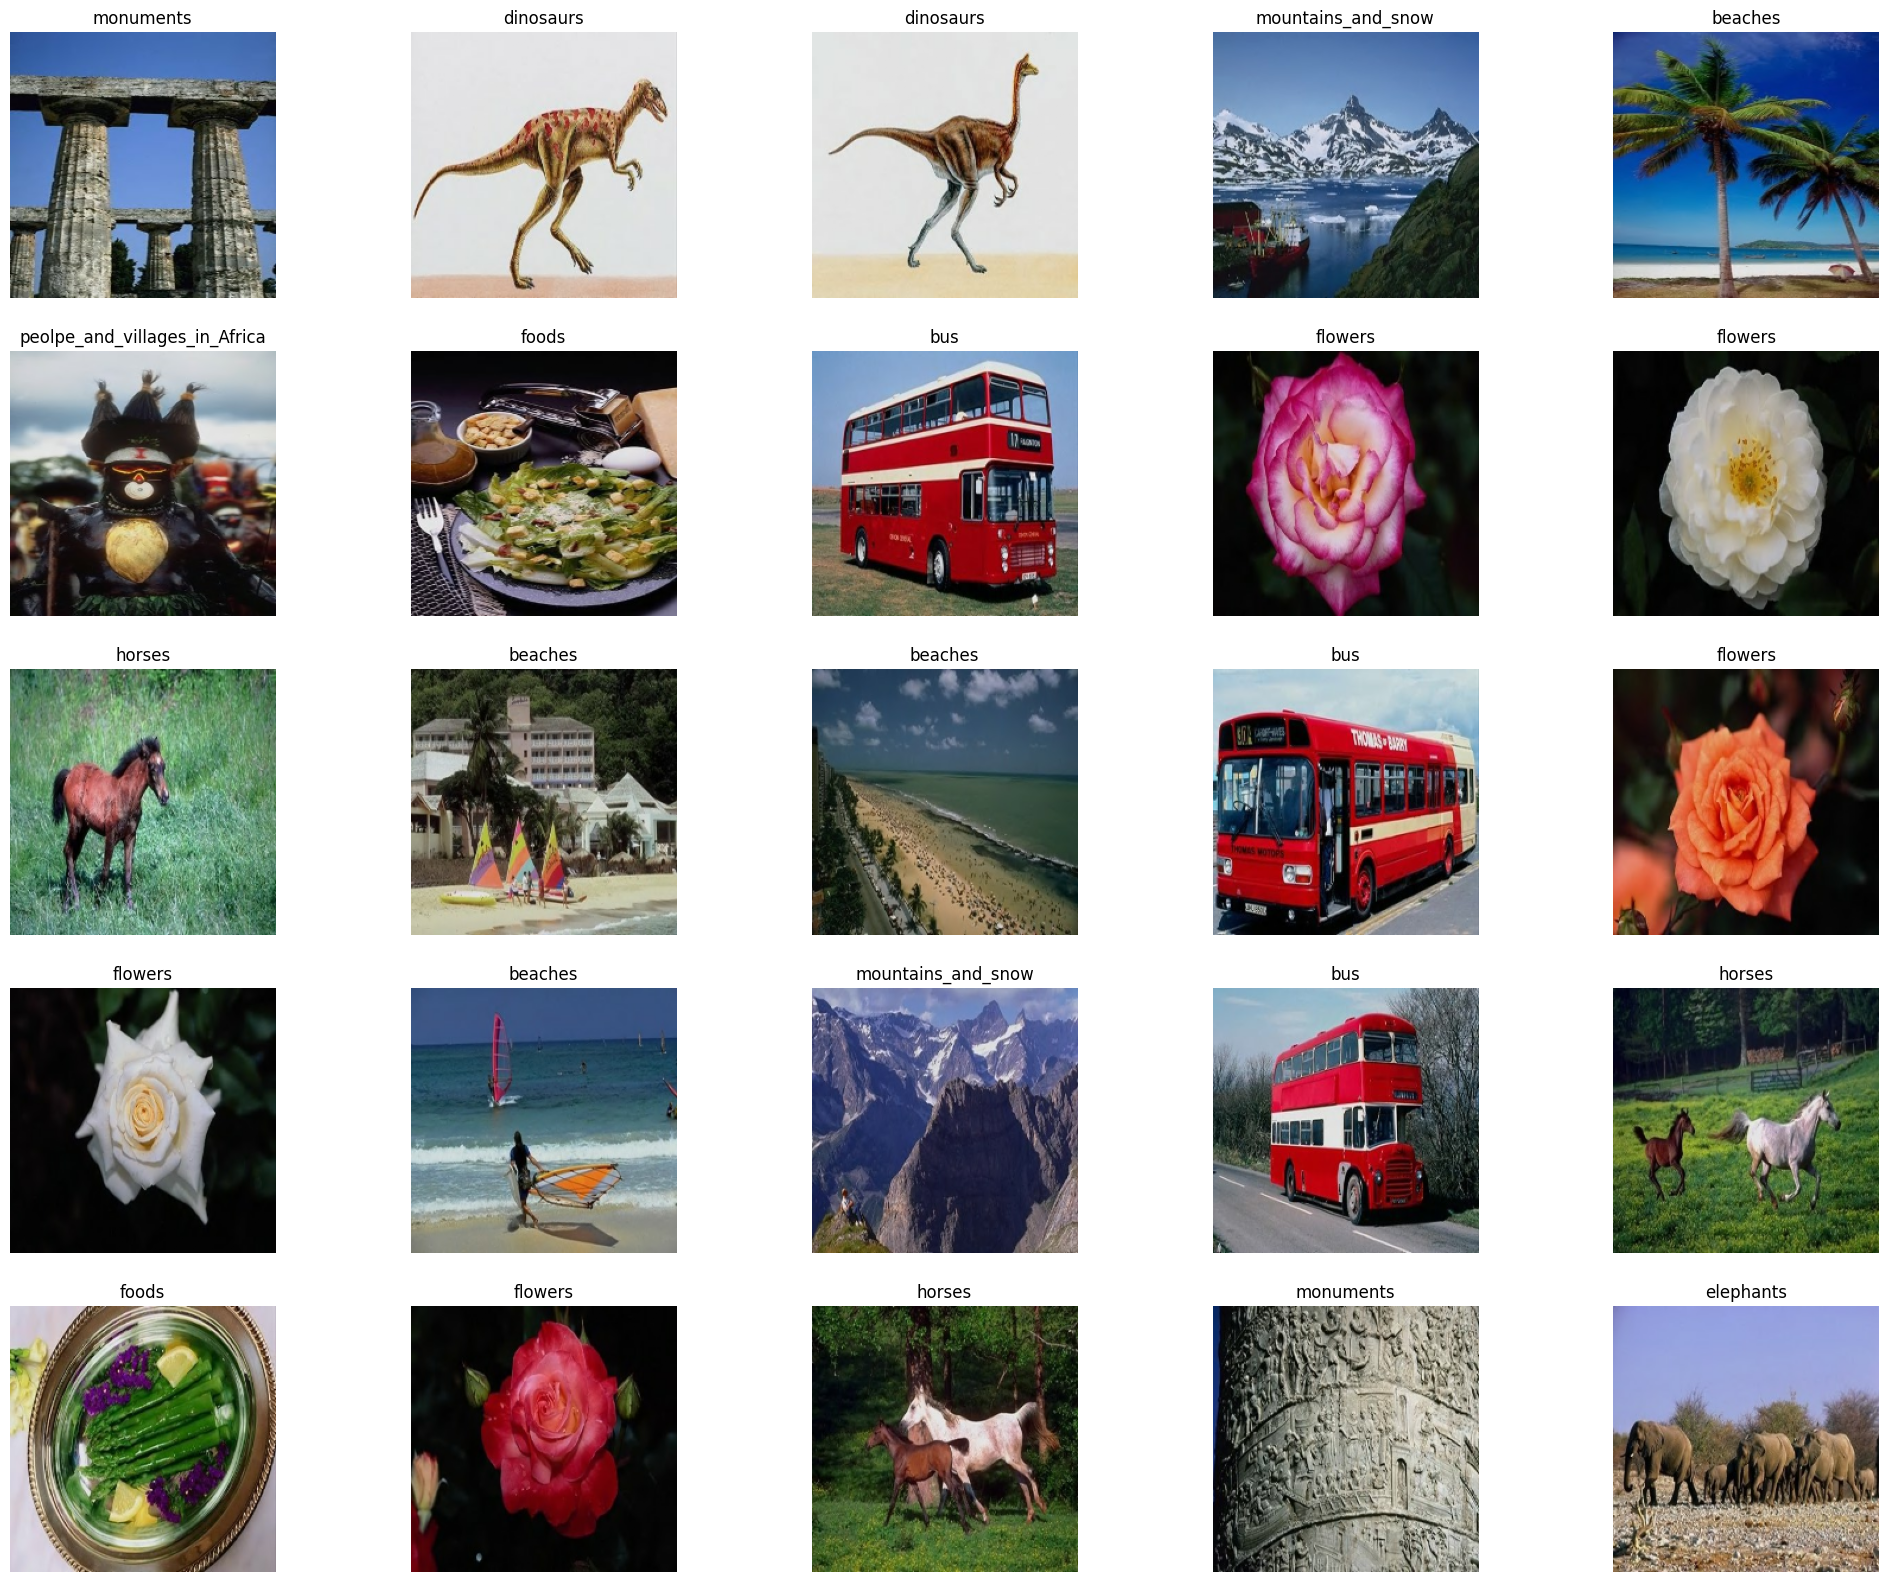

In [15]:
# Using in-built method
Image_data.show_random_images(image_paths=train_images, grid=(5,5))

In [16]:
# Converting the class weights from a list to dictionary
class_weights_dict = dict(zip(range(N_CLASSES), class_distribution_df["Class Weights"]))

In [17]:
class Model:
    models = [
        ResNet50V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        ResNet152V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        MobileNetV2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        Xception(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
    ]

    model_names = [
        "ResNet50V2",
        "ResNet152V2",
        "MobileNetV2",
        "Xception"
    ]

    def __init__(self, model_name: str):
        """
        Initialize the Model class with the specified pre-trained model.

        Args:
            model_name (str): Name of the pre-trained model to be used.
        """
        self.model_name = model_name
        self.index = self.model_names.index(model_name)
        self.backbone = self.models[self.index]

    def train(self, trainXs, trainYs, validation_data, epochs=10, batch_size=32, verbose=1):
        """
        Train the model using the specified training and validation data.

        Args:
            trainXs (numpy.ndarray): Training images.
            trainYs (numpy.ndarray): Training labels.
            validation_data: Validation data as a tuple (valXs, valYs).
            epochs (int): Number of epochs to train the model.
            batch_size (int): Batch size for training.
            verbose (int): Verbosity level for training logs (0, 1, or 2).
        """
        self.backbone.trainable = False

        self.model = Sequential([
            self.backbone,
            GlobalAveragePooling2D(),
            Dropout(0.4),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(N_CLASSES, activation='softmax')
        ])

        self.model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=['accuracy']
        )

        self.history = self.model.fit(
            trainXs, trainYs,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights_dict,
            steps_per_epoch=len(trainXs)//batch_size,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=verbose
        )

    def visualize_training(self):
        """
        Visualize the training history.
        """
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"{self.model_name} Training Curve")

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label="Loss", color="g")
        plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (crossentropy)")
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
        plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.legend()

        plt.show()

    def evaluate(self, testXs, testYs, verbose=1, visualize=False):

        test_loss, test_acc = self.model.evaluate(testXs, testYs, verbose=verbose)

        if visualize:
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{self.model_name} Performance Check")
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['loss'], label="Loss", color="g")
            plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
            plt.axhline(test_loss, color='black', alpha=0.8, linestyle="--", label="Test Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss (crossentropy)")
            plt.grid()
            plt.ylim([0, 1.5])
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
            plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
            plt.axhline(test_acc, color='black', alpha=0.8, linestyle="--", label="Test Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0.4, 1.0])
            plt.grid()
            plt.legend()

            plt.show()
        else:
            return test_loss, test_acc

83683744/83683744 [==============================] - 4s 0us/step


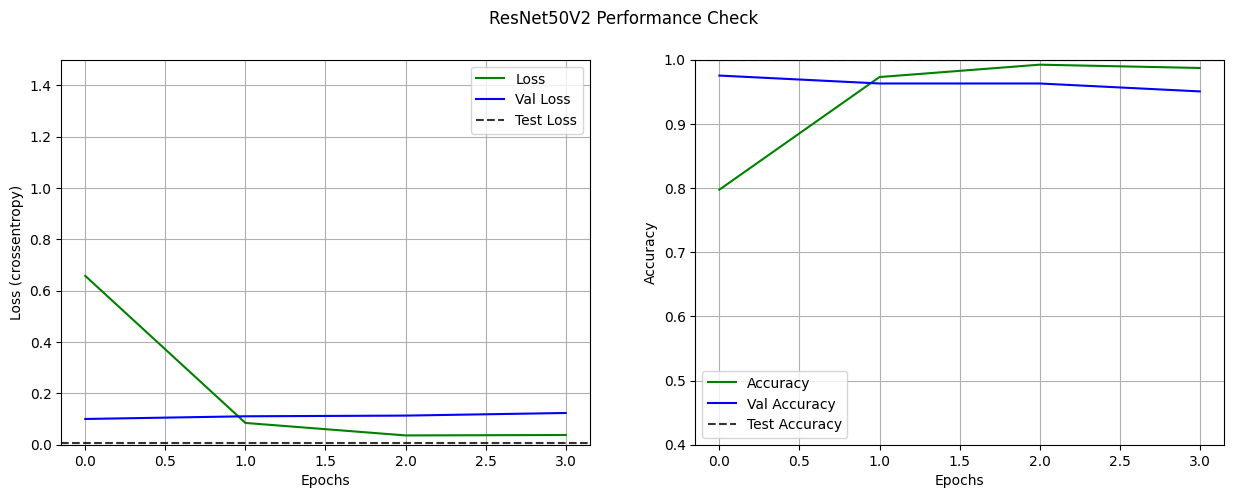

In [18]:
# Initialize the ResNet50V2 model
resnet50_model = Model(model_name="ResNet50V2")

# Train the model
resnet50_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
resnet50_model.evaluate(testXs, testYs, visualize=True, verbose=0)

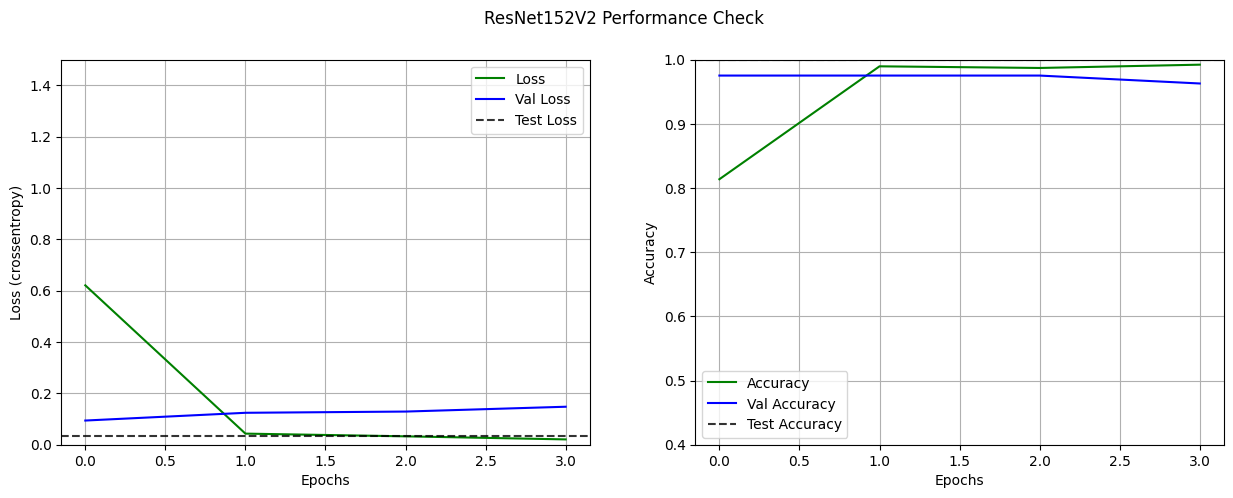

In [19]:
# Initialize the ResNet152V2 model
resnet152_model = Model(model_name="ResNet152V2")

# Train the model
resnet152_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
resnet152_model.evaluate(testXs, testYs, visualize=True, verbose=0)

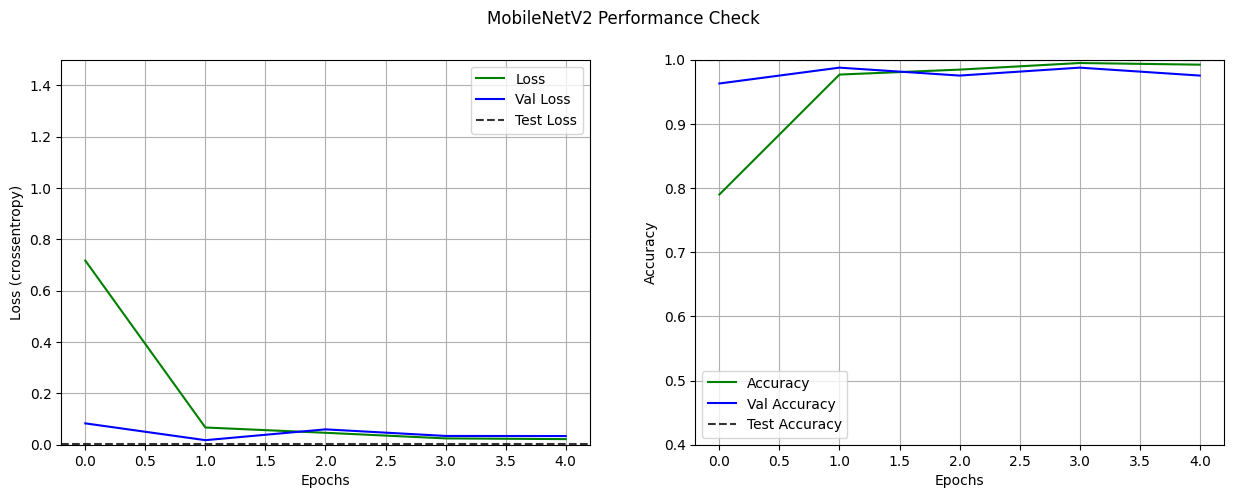

In [20]:
# Initialize the MobileNetV2 model
mobilenetv2_model = Model(model_name="MobileNetV2")

# Train the model
mobilenetv2_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
mobilenetv2_model.evaluate(testXs, testYs, visualize=True, verbose=0)

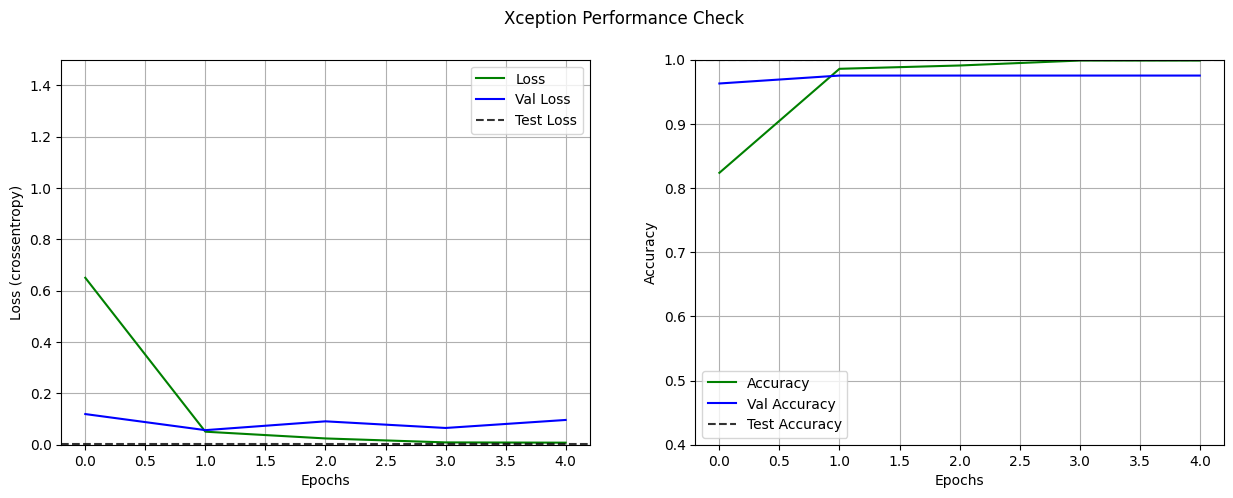

In [21]:
# Initialize the Xception model
xception_model = Model(model_name="Xception")

# Train the model
xception_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
xception_model.evaluate(testXs, testYs, visualize=True, verbose=0)

In [22]:
def build_model(hp):

    model_base = Xception(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE)
    model_base.trainable = True

    model = Sequential([
        model_base,
        GlobalAveragePooling2D(),
        Dropout(hp.Choice("rate", [0.4, 0.5])),
    ])

    for _ in range(hp.Choice("n_layers", [1, 2, 3])):
        model.add(
            Dense(hp.Choice("Units", [128, 256, 1024]), activation="relu"),
        )
    model.add(Dense(N_CLASSES, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-4, 1e-6])),
        metrics=['accuracy']
    )

    return model

In [ ]:
kt = Hyperband(
    build_model,
    max_epochs=5,
    objective='val_accuracy',
    project_name="XceptionHS",
    overwrite=True,
    factor=5
)
kt.search(trainXs, trainYs, validation_data=(validXs, validYs))

Trial 4 Complete [00h 14m 43s]
val_accuracy: 0.14814814925193787

Best val_accuracy So Far: 0.14814814925193787
Total elapsed time: 00h 56m 04s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
0.5               |0.4               |rate
1                 |1                 |n_layers
256               |256               |Units
1e-06             |1e-06             |lr
1                 |1                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round



In [ ]:
# Extract the Best Model
best_model = kt.get_best_models()[0]

# The best model architecture
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                        

In [ ]:
# Model evaluation
train_loss, train_acc = best_model.evaluate(trainXs, trainYs, verbose=0)
valid_loss, valid_acc = best_model.evaluate(validXs, validYs, verbose=0)
test_loss, test_acc = best_model.evaluate(testXs, testYs, verbose=0)

# Visualizing Model Performance
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Model Loss")
plt.bar(["Train", "Valid", "Test"], [train_loss, valid_loss, test_loss])
plt.grid()

plt.subplot(1,2,2)
plt.title("Model Accuracy")
plt.bar(["Train", "Valid", "Test"], [train_acc, valid_acc, test_acc])
plt.grid()

plt.show()

In [ ]:
# Define the number of rows and columns for the grid of images
n_rows, n_cols = [5, 5]
n_images = n_rows * n_cols

# Generate random image indexes from the test set
image_indexes = random.sample(range(len(testXs)), 25)

# Create a larger figure for displaying the grid of images
plt.figure(figsize=(25, 20))

# Iterate over the selected image indexes and plot each image with labels
for plot_index, index in enumerate(image_indexes):

    # Get the image and its corresponding true label
    image = testXs[index]
    true_label = class_names[np.argmax(testYs[index])]

    # Make a prediction using the trained model and get the predicted label
    prediction = best_model.predict(tf.expand_dims(image, axis=0), verbose=0)[0]
    predicted_label = class_names[tf.argmax(prediction)]

    # Create a subplot within the grid
    plt.subplot(n_rows, n_cols, plot_index + 1)

    # Display the image
    plt.imshow(image)

    # Set the title to show the true and predicted labels
    plt.title(f"True: {true_label}\nPred: {predicted_label}")

    # Turn off the axis ticks for cleaner presentation
    plt.axis('off')

# Display the grid of images
plt.show()

In [ ]:
# Saving the model weights
best_model.save("XceptionClassifier.h5")